In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
os.getcwd()

'D:\\TAMU Work\\Projects GIT\\rock-paper-scissors\\rockpaperscissors'

In [5]:
if os.path.isdir('train/rock') is False:
    os.makedirs('train/rock')
    os.makedirs('train/paper')
    os.makedirs('train/scissors')
    os.makedirs('train/none')
    os.makedirs('valid/rock')
    os.makedirs('valid/paper')
    os.makedirs('valid/scissors')
    os.makedirs('valid/none')
    os.makedirs('test/rock')
    os.makedirs('test/paper')
    os.makedirs('test/scissors')
    os.makedirs('test/none')
    
    for i in random.sample(glob.glob('images/rock/*'), 600):
        shutil.move(i, 'train/rock')
    for i in random.sample(glob.glob('images/paper/*'), 600):
        shutil.move(i, 'train/paper')
    for i in random.sample(glob.glob('images/scissors/*'), 600):
        shutil.move(i, 'train/scissors')
    for i in random.sample(glob.glob('images/none/*'), 600):
        shutil.move(i, 'train/none')
    for i in random.sample(glob.glob('images/rock/*'), 50):
        shutil.move(i, 'valid/rock')
    for i in random.sample(glob.glob('images/paper/*'), 50):
        shutil.move(i, 'valid/paper')
    for i in random.sample(glob.glob('images/scissors/*'), 50):
        shutil.move(i, 'valid/scissors')
    for i in random.sample(glob.glob('images/none/*'), 50):
        shutil.move(i, 'valid/none')
    for i in random.sample(glob.glob('images/rock/*'), 50):
        shutil.move(i, 'test/rock')
    for i in random.sample(glob.glob('images/paper/*'), 50):
        shutil.move(i, 'test/paper')
    for i in random.sample(glob.glob('images/scissors/*'), 50):
        shutil.move(i, 'test/scissors')
    for i in random.sample(glob.glob('images/none/*'), 50):
        shutil.move(i, 'test/none')

In [14]:
os.getcwd()
if os.path.isdir('aug/rock') is False:
    os.makedirs('aug/rock')
    os.makedirs('aug/paper')
    os.makedirs('aug/scissors')
    os.makedirs('aug/none')

In [18]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)

In [19]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

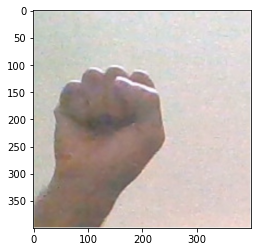

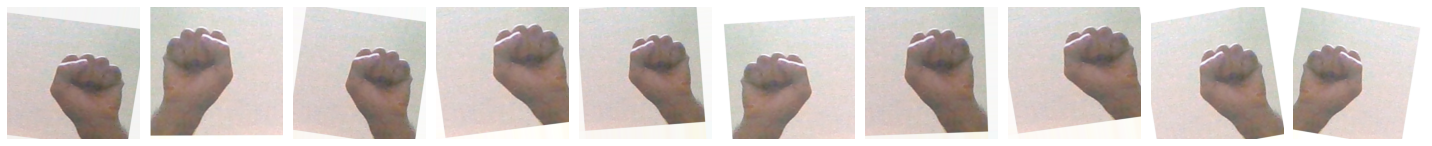

In [20]:
chosen_image = random.choice(os.listdir('train/rock'))
image_path = 'train/rock/' + chosen_image
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])
aug_iter = gen.flow(image)
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
plotImages(aug_images)
# aug_iter = gen.flow(image, save_to_dir='aug/rock', save_prefix='aug-rock-', save_format='jpeg')

In [21]:
os.getcwd()

'D:\\TAMU Work\\Projects GIT\\rock-paper-scissors\\rockpaperscissors'

In [23]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

In [24]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['none', 'paper', 'rock', 'scissors'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['none', 'paper', 'rock', 'scissors'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['none', 'paper', 'rock', 'scissors'], batch_size=10, shuffle=False)

Found 2400 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


In [25]:
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

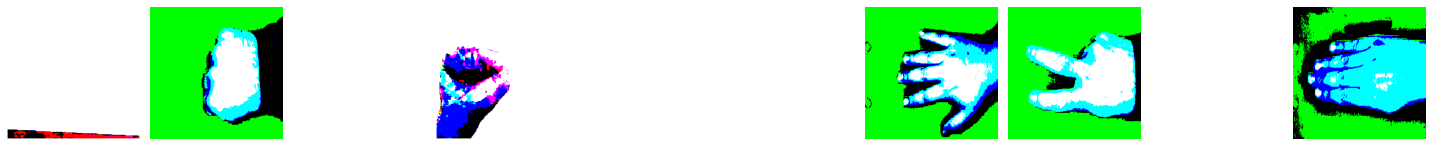

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [26]:
plotImages(imgs)
print(labels)

In [27]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=4, activation='softmax')
])

In [28]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=1
)

Epoch 1/10
240/240 [==============================] - 22s 77ms/step - loss: 37.5056 - accuracy: 0.6732 - val_loss: 2.8456 - val_accuracy: 0.8850 ETA: 15s - loss: 121.7691 - accuracy:  - ETA: 14s - loss: 115. - ETA: 13s - loss: 95.6166 -  - ETA: 12s - loss: 88.9315 - accuracy: 0.45 - ETA: 12s - loss: 88.1675 - accuracy - ETA: 11s - loss: 72.0408 - accuracy:  - ETA: 10s - loss: 70.6545 - accuracy - ETA: 10s - loss: 68.8991 - accuracy - ETA: 10s - loss: 67.2445 - accuracy: 0. - ETA: 10s - loss: 66.4540 - ac - ETA: 9s - loss: 62.8182 - ETA: 8s - loss: 57.0795 - acc - ETA: 7s - loss:  - ETA: 5s - loss: 48.2204 - accuracy: - ETA: 4s - loss: 46.8117 - accuracy: 0.6 - ETA: 4s - loss: 46.3074 - accuracy: - ETA: 4s - loss: 45.17 - ETA: 2s - loss: 42.1432 - accuracy: 0 - ETA: 2s - loss: 41.4903 - accuracy: 0.6 - ETA: 2s - loss: 41.1097 - accuracy: 0. - ETA: 1s - loss: 40.6151 - accuracy: 0. - ETA: 1s - loss: 40.1340 - accuracy: 0. - ETA: 1s - loss: 39.6658 -  - ETA: 0s - loss: 37.9150 - accuracy:

In [30]:
test_imgs, test_labels = next(test_batches)

In [31]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [32]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [34]:
test_batches.class_indices

{'none': 0, 'paper': 1, 'rock': 2, 'scissors': 3}

Confusion matrix, without normalization
[[50  0  0  0]
 [ 0 43  5  2]
 [ 0  0 50  0]
 [ 0  0  3 47]]


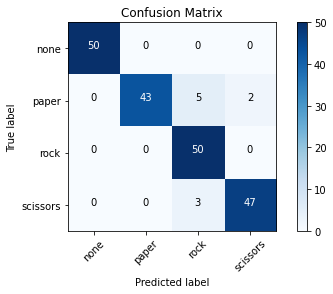

In [35]:
cm_plot_labels = ['none','paper', 'rock','scissors']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [36]:
model.save('models/rpsmodel')

INFO:tensorflow:Assets written to: models/rpsmodel\assets
